### Dataset
Lets Load the dataset. We shall use the following datasets:
Features are in: "sido0_train.mat"
Labels are in: "sido0_train.targets"

In [191]:
from scipy.io import loadmat
import numpy as np

X = loadmat(r"/Users/rkiyer/Desktop/teaching/CS6301/jupyter/data/sido0_matlab/sido0_train.mat")
y = np.loadtxt(r"/Users/rkiyer/Desktop/teaching/CS6301/jupyter/data/sido0_matlab/sido0_train.targets")

# Statistics of the Dense Format of X
X = X['X'].todense()
print(X.shape)

(12678, 4932)


### Logistic Regression Definition
Lets define now L1 regularized Logistic Loss


In [192]:
def LogisticLoss(w, X, y, lam):
    # Computes the cost function for all the training samples
    m = X.shape[0]
    n = X.shape[1]
    Xw = np.dot(X,w)
    yT = y.reshape(-1,1)
    yXw = np.multiply(yT,Xw)
    f = np.sum(np.logaddexp(0,-yXw)) + lam*np.sum(np.abs(w))
    gMul = 1/(1 + np.exp(yXw))
    ymul = -1*np.multiply(yT, gMul)
    g =  np.dot(ymul.reshape(1,-1),X) + lam*np.sign(w).reshape(1,-1)
    g = g.reshape(-1,1)
    return [f, g]      

In [193]:
[nSamples,nVars] = X.shape
w = np.zeros((nVars,1))
[f,g] = LogisticLoss(w, X, y, 1)
print(f)
print(g)

8787.719955138986
[[503.5]
 [292. ]
 [ 21.5]
 ...
 [556.5]
 [118. ]
 [194.5]]


### Reinvoking Gradient Descent Armiojo
Lets invoke the final version of Armijo Line Search GD

In [194]:
from numpy import linalg as LA

def gd(funObj,w,maxEvals,alpha,X,y,lam, verbosity, freq):
    [f,g] = funObj(w,X,y,lam)
    funEvals = 1
    funVals = []
    while(1):
        [f,g] = funObj(w,X,y,lam)
        optCond = LA.norm(g, np.inf)
        if ((verbosity > 0) and (funEvals % freq == 0)):
            print(funEvals,alpha,f,optCond)
        w = w - alpha*g
        funEvals = funEvals+1
        if (optCond < 1e-2):
            break
        if (funEvals > maxEvals):
            break
        funVals.append(f)
    return funVals

def gdArmijo(funObj,w,maxEvals,alpha,gamma,X,y,lam, verbosity, freq):
    [f,g] = funObj(w,X,y,lam)
    funEvals = 1
    funVals = []
    f_old = f
    g_old = g
    funVals.append(f)
    alpha = 1
    numBackTrack = 0
    while(1):
        wp = w - alpha*g
        [fp,gp] = funObj(wp,X,y,lam)
        funVals.append(f)
        funEvals = funEvals+1
        backtrack = 0
        while fp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha*alpha*np.dot(g.T, g)[0,0]/(2*(fp + np.dot(g.T, g)[0,0]*alpha - f))
            wp = w - alpha*g
            [fp,gp] = funObj(wp,X,y,lam)
            funVals.append(f)
            funEvals = funEvals+1
            numBackTrack = numBackTrack + 1
        if funEvals > 2:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, g)[0,0])
        f_old = f
        g_old = g
        w = wp
        f = fp
        g = gp
        optCond = LA.norm(g, np.inf)
        if ((verbosity > 0) and (funEvals % freq == 0)):
            print(funEvals,alpha,f,optCond)
        if (optCond < 1e-2):
            break
        if (funEvals >= maxEvals):
            break
    return (funVals,numBackTrack)

### Proximal Gradient Descent
Now lets implement Proximal

In [181]:
from numpy import linalg as LA

mu = 1
def L1Prox(x, lam):
    maxx = np.maximum(np.abs(x) - lam*mu, 0)
    return np.multiply(maxx, np.sign(x))

def gdProx(funObj,w,maxEvals,alpha,X,y,lam, verbosity, freq):
    [f,g] = funObj(w,X,y,lam)
    funEvals = 1
    funVals = []
    while(1):
        [f,g] = funObj(w,X,y,0)
        optCond = LA.norm(g, np.inf)
        if ((verbosity > 0) and (funEvals % freq == 0)):
            print(funEvals,alpha,f,optCond)
        w = L1Prox(w - alpha*g,lam*alpha)
        funEvals = funEvals+1
        if (optCond < 1e-2):
            break
        if (funEvals > maxEvals):
            break
        funVals.append(f)
    return funVals

def gdProxArmijo(funObj,w,maxEvals,alpha,gamma,X,y,lam, verbosity, freq):
    [f,g] = funObj(w,X,y,0)
    funEvals = 1
    funVals = []
    f_old = f
    g_old = g
    funVals.append(f)
    alpha = 1
    numBackTrack = 0
    while(1):
        wp = L1Prox(w - alpha*g,alpha*lam)
        [fp,gp] = funObj(wp,X,y,0)
        funVals.append(f)
        funEvals = funEvals+1
        backtrack = 0
        while fp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha*alpha*np.dot(g.T, g)[0,0]/(2*(fp + np.dot(g.T, g)[0,0]*alpha - f))
            wp = L1Prox(w - alpha*g,lam*alpha)
            [fp,gp] = funObj(wp,X,y,0)
            funVals.append(f)
            funEvals = funEvals+1
            numBackTrack = numBackTrack + 1
        if funEvals > 2:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, g)[0,0])
        f_old = f
        g_old = g
        w = wp
        f = fp
        g = gp
        optCond = LA.norm(g, np.inf)
        if ((verbosity > 0) and (funEvals % freq == 0)):
            print(funEvals,alpha,f,optCond)
        if (optCond < 1e-2):
            break
        if (funEvals >= maxEvals):
            break
    return (funVals,numBackTrack)

In [185]:
[nSamples,nVars] = X.shape
w = np.zeros((nVars,1))
print("Gradient Descent with Fixed Step Size")
funV1 = gd(LogisticLoss,w,200,1e-5,X,y,1000,1,10)
print(len(funV1))
print("Gradient Descent with Backtracking Line Search")
(funV2,numBackTrack) = gdArmijo(LogisticLoss,w,200,1,1e-4,X,y,1000,1,10)
print(len(funV2))
print("Number of Backtrackings = " + str(numBackTrack))

Gradient Descent with Fixed Step Size
10 1e-05 25483.458111208987 1318.165161847604
20 1e-05 28174.671349879456 1271.76399300516
30 1e-05 34043.01227034802 1404.3636619139188
40 1e-05 30346.176427273946 1351.1312121214416
50 1e-05 35524.90509051614 1410.4548179904532
60 1e-05 32199.107914998018 1387.2329308605804
70 1e-05 31392.224061468136 1380.106049412477
80 1e-05 32667.859332787804 1398.7549782211106
90 1e-05 30788.29140257608 1368.8791051250455
100 1e-05 32545.655986155758 1395.7281700648925
110 1e-05 29787.699474075103 1343.9294118117182
120 1e-05 29336.54378554532 1311.895386403687
130 1e-05 31920.301586768965 1387.4926194929058
140 1e-05 33292.894791505896 1403.806952771307
150 1e-05 29601.687563686126 1344.4449250864093
160 1e-05 32629.940009878974 1399.419798719683
170 1e-05 30101.55044672699 1347.9862901168767
180 1e-05 33724.27042445242 1405.6284714989056
190 1e-05 29760.52240155365 1345.8794988936215
200 1e-05 32007.02668790054 1389.405963235599
199
Gradient Descent with B

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


20 1.4088759485544872e-07 7077.719863352558 1860.6086697728492
30 8.313546216299688e-09 6629.862512634738 1845.1737521321706
40 3.3455937772699538e-09 6556.705269974167 1843.1842969400523
50 1.2557022591437148e-10 6548.129271462571 1842.6636660832119
60 3.355302803325746e-10 6544.37748462888 1842.4801207285454
70 4.9051151424008995e-11 6543.443175067647 1842.4497824196078
80 1.0325039536393731e-11 6543.274002088672 1842.4435246401163
90 2.13335581249387e-12 6543.237870068007 1842.4423131138674
100 3.5325304179109113e-13 6543.2336105628365 1842.4421202593758
110 7.950098487337587e-14 6543.232188062712 1842.4420818232647
120 1.7868879958084857e-14 6543.231896107758 1842.442071783773
130 0.0 6543.2318614986125 1842.442071064147
140 0.0 6543.23185715939 1842.4420709112064
150 0.0 6543.231855210681 1842.442070843923
160 0.0 6543.231854791848 1842.442070830396
170 0.0 6543.231854743397 1842.4420708281405
180 0.0 6543.231854741502 1842.442070828085
190 0.0 6543.231854731518 1842.442070827714


In [186]:
[nSamples,nVars] = X.shape
w = np.zeros((nVars,1))
print("Proximal Gradient Descent with Fixed Step Size")
(funV3) = gdProx(LogisticLoss,w,200,1e-5,X,y,1000,1,10)
print(len(funV3))
#print("Proximal Gradient Descent with Backtracking Line Search")
#(funV1,numBackTrack) = gdProxArmijo(LogisticLoss,w,200,1,1e-4,X,y,1000,1,10)
#print(len(funV1))
#print("Number of Backtrackings = " + str(numBackTrack))

Proximal Gradient Descent with Fixed Step Size
10 1e-05 2636.788990359461 1355.3541907312065
20 1e-05 2522.4094780052596 1241.1177191366498
30 1e-05 2476.492028975414 1198.6590906761421
40 1e-05 2445.8466936273685 1170.270448987063
50 1e-05 2418.0767937525343 1141.3717745909807
60 1e-05 2397.552084345081 1119.5245640500075
70 1e-05 2380.2692054497343 1100.2119196972003
80 1e-05 2360.213428295232 1078.5976530015273
90 1e-05 2351.6236064501545 1069.13244346509
100 1e-05 2349.1573147351933 1065.8799951955393
110 1e-05 2345.168520074747 1060.811929376459
120 1e-05 2341.0091688481543 1055.3118032811078
130 1e-05 2338.326860674283 1051.611196823867
140 1e-05 2337.748939954794 1049.9987710632922
150 1e-05 2332.8626368581536 1043.762821189623
160 1e-05 2326.6239347212163 1036.565160878359
170 1e-05 2325.0562761959272 1034.1551077883082
180 1e-05 2325.022897948621 1033.2962336178455
190 1e-05 2325.3024594330054 1032.750999556637
200 1e-05 2322.6750791997874 1029.1253458192427
199


Text(0, 0.5, 'Function Value')

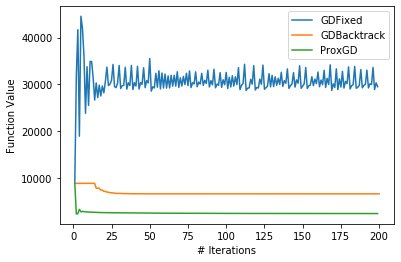

In [190]:
from matplotlib import pyplot as plt
plt.plot(range(1,len(funV1)+1), funV1, label='GDFixed')
plt.plot(range(1,len(funV2)+1), funV2, label='GDBacktrack')
plt.plot(range(1,len(funV3)+1), funV3, label='ProxGD')
plt.legend()
plt.xlabel("# Iterations")
plt.ylabel("Function Value")